### Import Libraries

In [1]:
from utils import log_to_token_seq, split_log
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import random


### Initialize path variables

In [2]:
template_paths = [
    r"nulog\logs\Linux\Linux_2k.log_templates.csv",
    r"nulog\logs\Andriod\Andriod_2k.log_templates.csv",     
    r"nulog\logs\Apache\Apache_2k.log_templates.csv",
    r"nulog\logs\BGL\BGL_2k.log_templates.csv",
    r"nulog\logs\Hadoop\Hadoop_2k.log_templates.csv",
    r"nulog\logs\HDFS\HDFS_2k.log_templates.csv",
    r"nulog\logs\HealthApp\HealthApp_2k.log_templates.csv",
    r"nulog\logs\HPC\HPC_2k.log_templates.csv",
    r"nulog\logs\Mac\Mac_2k.log_templates.csv",
    r"nulog\logs\OpenSSH\OpenSSH_2k.log_templates.csv",
    r"nulog\logs\OpenStack\OpenStack_2k.log_templates.csv",
    r"nulog\logs\Proxifier\Proxifier_2k.log_templates.csv",
    r"nulog\logs\Spark\Spark_2k.log_templates.csv",
    r"nulog\logs\Thunderbird\Thunderbird_2k.log_templates.csv",
    r"nulog\logs\Windows\Windows_2k.log_templates.csv",
    r"nulog\logs\Zookeeper\Zookeeper_2k.log_templates.csv"
    ]

In [3]:
log_paths = [
    r"nulog\logs\Andriod\Andriod_2k.log",
    r"nulog\logs\Apache\Apache_2k.log",
    r"nulog\logs\BGL\BGL_2k.log",
    r"nulog\logs\Hadoop\Hadoop_2k.log",
    r"nulog\logs\HDFS\HDFS_2k.log",
    r"nulog\logs\HealthApp\HealthApp_2k.log",
    r"nulog\logs\HPC\HPC_2k.log",
    r"nulog\logs\Linux\Linux_2k.log",
    r"nulog\logs\Mac\Mac_2k.log",
    r"nulog\logs\OpenSSH\OpenSSH_2k.log",
    r"nulog\logs\OpenStack\OpenStack_2k.log",
    r"nulog\logs\Proxifier\Proxifier_2k.log",
    r"nulog\logs\Spark\Spark_2k.log",
    r"nulog\logs\Thunderbird\Thunderbird_2k.log",
    r"nulog\logs\Windows\Windows_2k.log",
    r"nulog\logs\Zookeeper\Zookeeper_2k.log"
]

In [4]:
def get_labels(log, template):
    label = [0] * len(log)
    j = 0
    for i in range(len(log)):
        if log[i] == template[j]:
            label[i] = 0
            j += 1
        elif template[j] == '<*>':
            if j+1 < len(template) and log[i] == template[j+1]:
                j += 2
            else:
                label[i] = 1
        else:
            print("smth wrong", log[i], template[j], log, template)
    return label

### Initialize device (GPU if available)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Create the dataset adapted to the task

In [104]:
from torch.utils.data import Dataset
import torch
from ast import literal_eval


class LogDataset(Dataset):
    def __init__(self, log_paths, vocab_size, max_length=300, special_offset=10):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.special_offset = special_offset
        self.logs = []
        self.labels = []
        self.data = []  # List of (token_sequence, mask_index)

        for log_path in log_paths:
            log_path += '_structured.csv'
            df = pd.read_csv(log_path)
            for row in df.iterrows():
                log = row[1]['Content']
                labels = row[1]['labels']
                tok_seq = log_to_token_seq(log.strip(), self.special_offset)
                if len(tok_seq) == 0:
                    continue
                # Truncate or pad token sequence
                tok_seq = tok_seq[:self.max_length]
                for i in range(len(tok_seq)):
                    self.logs.append(log)
                    self.labels.append(literal_eval(labels))
                    self.data.append((tok_seq, i))  # One example per masked token
                    

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tok_seq, mask_idx = self.data[idx]
        tokens = tok_seq[:self.max_length]
        input_ids = tokens + [0] * (self.max_length - len(tokens))
        labels = [-100] * self.max_length  # Only one label exposed

        # Mask only the selected token
        labels[mask_idx] = input_ids[mask_idx]
        input_ids[mask_idx] = 1  # [MASK] token

        attention_mask = [1 if t != 0 else 0 for t in input_ids]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }


In [8]:
def tokenize(log):
    tok_seq = log_to_token_seq(log,10)
    return torch.tensor(tok_seq[:300], dtype=torch.long)

In [9]:
def get_input(log):
    inputs = tokenize(log)
    inputs = inputs.reshape((1,-1)).to(device)

    repeat_inputs = inputs.repeat(inputs.shape[1],1)

    mask = torch.eye(inputs.shape[1]).to(device)

    masked_inputs = repeat_inputs.masked_fill(mask == 1, 1)
    labels = repeat_inputs.masked_fill(masked_inputs != 1, -100)

    return masked_inputs


In [85]:
dataset = LogDataset(log_paths, 30000)
from torch.utils.data import DataLoader 
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
print(batch)

{'input_ids': tensor([[  228,  2544,  3026,  ...,     0,     0,     0],
        [ 1397,  2246, 16171,  ...,     0,     0,     0],
        [  986,  1088,  2573,  ...,     0,     0,     0],
        ...,
        [  453,     1,   696,  ...,     0,     0,     0],
        [10627,  1424,   515,  ...,     0,     0,     0],
        [ 2729,  2544, 23047,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        ...,
        [-100, 2708, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]])}


In [ ]:
from torch.utils.data import random_split

train_size = int(0.98 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


### Configurate the BERT MLM model

In [ ]:
from transformers import BertConfig, BertForMaskedLM, Trainer, TrainingArguments


# Step 1: Define model config
config = BertConfig(
    vocab_size=30000,           # keep this as is
    max_position_embeddings=300,  # fine
    num_attention_heads=1,      # ↓ reduce attention heads
    num_hidden_layers=2,        # ↓ fewer transformer blocks
    type_vocab_size=1,
    hidden_size=64,            # ↓ smaller embedding and hidden dims
    intermediate_size=256,     # ↓ smaller feed-forward layer
)
# Step 2: Create model
#model = BertForMaskedLM(config)
#model = model.to(device)

In [ ]:
#optional: create subset of the dataset to a faster training
from torch.utils.data import Subset
import random

# Fix a seed for reproducibility
random.seed(42)

# Choose subset size
n_train = train_size // 5  # adjust as needed
n_eval = val_size // 5
#print(n_train)
#print(n_eval)

# Sample indices
train_indices = random.sample(range(len(train_dataset)), n_train)
eval_indices = random.sample(range(len(val_dataset)), n_eval)

print(train_indices[1])
print(eval_indices[1])

# Create subset datasets
small_train_dataset = Subset(train_dataset, train_indices)
small_eval_dataset = Subset(val_dataset, eval_indices)

26225
5786


### Train the MLM model

In [16]:
training_args = TrainingArguments(
    output_dir="./results_v2",
    eval_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
)


In [45]:
trainer.train()

Step,Training Loss,Validation Loss
10,7.481100,7.759139
20,7.435300,7.725691
30,7.402700,7.691646
40,7.385500,7.656644
50,7.547500,7.621933
60,7.360800,7.587062
70,7.427800,7.552222
80,7.405300,7.517879
90,7.402600,7.484166
100,7.336300,7.450078


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


TrainOutput(global_step=14936, training_loss=5.439206581800202, metrics={'train_runtime': 10448.0087, 'train_samples_per_second': 91.475, 'train_steps_per_second': 1.43, 'total_flos': 231183160358400.0, 'train_loss': 5.439206581800202, 'epoch': 4.0})

In [ ]:
# import saved model from checkpoint
best_model = BertForMaskedLM.from_pretrained(r"results_v2\checkpoint-14936")
model = best_model.to(device)

### Evaluate MLM model

In [ ]:
# 
logs_test = [dataset.logs[idx] for idx in train_indices]
labels_test = [dataset.labels[idx] for idx in train_indices]

In [92]:
def compute_entropy(token_probs):
    
    entropy = -torch.sum(token_probs * torch.log(token_probs + 1e-20)).item()
    return entropy

In [93]:
def topk_entropy(token_probs, topk = 5):
    topk_probs, topk_indices = torch.topk(token_probs, k=topk)

    entropy = -torch.sum(topk_probs * torch.log(topk_probs + 1e-10)).item()
    return entropy

In [95]:
logs_test = [dataset.logs[idx] for idx in train_indices]
labels_test = [dataset.labels[idx] for idx in train_indices]

In [ ]:
# MLM Eval metrics
neg_entropy = []
pos_entropy = []
cnt = 0
pos_detect = []
neg_detect = []

In [ ]:

# MLM Eval 
for log, labels in zip(logs_test, labels_test):
    tokens = tokenize(log)
    cnt += 1
    inputs = get_input(log)
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits
        for i in range(logits.shape[0]):
            probs = F.softmax(logits[i][i], dim=-1)
            entropy = compute_entropy(probs)
            if labels[i]:
                pos_entropy.append(entropy)
            else:
                neg_entropy.append(entropy)

    if cnt == 30000:
        break

In [ ]:
#MLM topk accuracy of variable tokens (k=5)
sum(pos_detect)/len(pos_detect)

0.0001321972104069355

In [ ]:
##MLM topk accuracy of static tokens (k=5)
sum(neg_detect)/len(neg_detect)

0.0007551264286918718

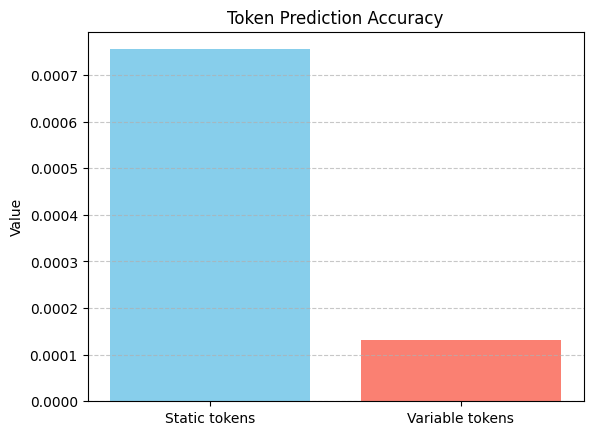

In [ ]:
# Plot MLM accuracy metrics
labels = ['Static tokens', 'Variable tokens']
values = [0.0007551264286918718, 0.0001321972104069355]

# Bar plot
plt.bar(labels, values, color=['skyblue', 'salmon'])
plt.ylabel('Value')
plt.title('Token Prediction Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# MLM entropy comparision
print(torch.Tensor(neg_entropy).mean()) # static

print(torch.Tensor(pos_entropy).mean()) # variable


tensor(4.7876)
tensor(5.1207)


C:\Users\I753367\AppData\Local\Temp\ipykernel_24368\2316259337.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x1, x2], labels=['Static token predictions', 'Variable token predictions'])


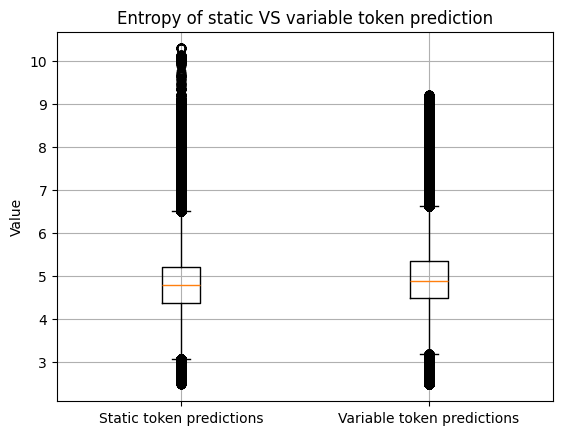

In [ ]:
# MLM Entropy distribution comparision
import matplotlib.pyplot as plt
import numpy as np
x1 = neg_entropy
x2 = pos_entropy


plt.boxplot([x1, x2], labels=['Static token predictions', 'Variable token predictions'])
plt.title('Entropy of static VS variable token prediction')
plt.ylabel('Value')
plt.grid(True)
plt.show()

### Prepare dataset for Token Classfication task

In [64]:
from torch.utils.data import Dataset
import torch
from ast import literal_eval


class LogForTokenClassificationDataset(Dataset):
    def __init__(self, log_paths, vocab_size, max_length=300, special_offset=10):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.special_offset = special_offset
        self.logs = []
        self.labels = []
        self.data = []  # List of (token_sequence, mask_index)

        for log_path in log_paths:
            log_path += '_structured.csv'
            df = pd.read_csv(log_path)
            for row in df.iterrows():
                log = row[1]['Content']
                labels = row[1]['labels']
                self.logs.append(log)
                self.labels.append(literal_eval(labels))

                    

    def __len__(self):
        return len(self.logs)

    def __getitem__(self, idx):
        log = self.logs[idx]
        tok_seq = log_to_token_seq(log.strip(), self.special_offset)
        tokens = tok_seq[:self.max_length]
        input_ids = tokens + [0] * (self.max_length - len(tokens))
        labels = self.labels[idx][:self.max_length]
        labels = labels + [-100] * (self.max_length - len(labels))
        
        attention_mask = [1 if t != 0 else 0 for t in input_ids]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }


In [65]:
dataset = LogForTokenClassificationDataset(log_paths, 30000)
from torch.utils.data import DataLoader 
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)



In [66]:
batch = next(iter(dataloader))
print(batch)

{'input_ids': tensor([[2763,   13, 2544,  ...,    0,    0,    0],
        [1071, 3079, 1905,  ...,    0,    0,    0],
        [1224, 2254, 1003,  ...,    0,    0,    0],
        ...,
        [3024,  743, 1332,  ...,    0,    0,    0],
        [ 260, 2624, 2624,  ...,    0,    0,    0],
        [ 305, 1864, 1914,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[   0,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    1,  ..., -100, -100, -100],
        [   1,    0,    0,  ..., -100, -100, -100],
        ...,
        [   0,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100]])}


In [67]:
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [68]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


### Configurate BERT for Token Classification 

In [69]:
import torch.nn as nn
from transformers import BertModel

class BertTokenClassifier(nn.Module):
    def __init__(self, bert_model_name_or_instance, num_labels=2):
        super().__init__()
        if isinstance(bert_model_name_or_instance, str):
            self.bert = BertModel.from_pretrained(bert_model_name_or_instance)
        else:
            self.bert = bert_model_name_or_instance
        
        self.config = self.bert.config

        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Flatten the predictions and labels for token-level classification
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return {"logits": logits, "loss": loss} if loss is not None else {"logits": logits}


In [70]:
from transformers import BertConfig, BertModel


# Option B: Load from your training checkpoint (custom)

model = BertModel.from_pretrained((r"results_v2\checkpoint-14936"))

#best_model = BertForMaskedLM.from_pretrained(r"results_v2\checkpoint-14936")
#model = best_model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at results_v2\checkpoint-14936 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
model = BertTokenClassifier(model)
model.to(device)

BertTokenClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 64, padding_idx=0)
      (position_embeddings): Embedding(300, 64)
      (token_type_embeddings): Embedding(1, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=T

### Train BERT for Token Classification

In [73]:
from torch.optim import AdamW
from tqdm import tqdm


optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")


100%|██████████| 1700/1700 [00:46<00:00, 36.91it/s]


Epoch 1 Loss: 149.2399


100%|██████████| 1700/1700 [00:48<00:00, 34.98it/s]


Epoch 2 Loss: 129.8751


100%|██████████| 1700/1700 [00:50<00:00, 33.42it/s]


Epoch 3 Loss: 114.8574


100%|██████████| 1700/1700 [00:50<00:00, 33.58it/s]


Epoch 4 Loss: 102.0167


100%|██████████| 1700/1700 [00:49<00:00, 34.33it/s]


Epoch 5 Loss: 93.0516


100%|██████████| 1700/1700 [00:49<00:00, 34.55it/s]


Epoch 6 Loss: 83.6652


100%|██████████| 1700/1700 [00:50<00:00, 33.34it/s]


Epoch 7 Loss: 75.7520


100%|██████████| 1700/1700 [00:50<00:00, 33.70it/s]


Epoch 8 Loss: 70.4242


100%|██████████| 1700/1700 [00:50<00:00, 33.72it/s]


Epoch 9 Loss: 64.9650


100%|██████████| 1700/1700 [00:49<00:00, 34.13it/s]

Epoch 10 Loss: 59.9296


### Evaluation of BERT for Token Classification

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs["logits"]  # shape: (batch_size, seq_len, num_classes)

        preds = torch.argmax(logits, dim=-1)

        # Flatten and filter out padding (-100 or 0 depending on your setting)
        for i in range(labels.size(0)):
            for j in range(labels.size(1)):
                label = labels[i][j].item()
                if label != -100:
                    all_labels.append(label)
                    all_preds.append(preds[i][j].item())


              precision    recall  f1-score   support

      static       0.99      0.99      0.99    322120
    variable       0.99      0.99      0.99    250642

    accuracy                           0.99    572762
   macro avg       0.99      0.99      0.99    572762
weighted avg       0.99      0.99      0.99    572762

[[319540   2580]
 [  1983 248659]]


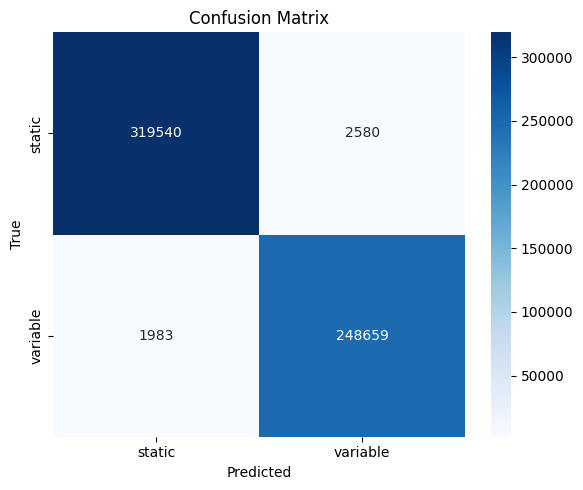

In [103]:
print(classification_report(all_labels, all_preds, target_names=["static", "variable"]))

cm = confusion_matrix(all_labels, all_preds)
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["static", "variable"], yticklabels=["static", "variable"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
